In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from minisom import MiniSom    

(1000, 3)
Star ID:  0.0 , lat: 166.87284204472166 , len:  272.54364624788235
Star ID:  1.0 , lat: 242.54915142953718 , len:  42.33018898914511
Star ID:  2.0 , lat: 63.13267997565467 , len:  239.8067005866083
Star ID:  3.0 , lat: 358.9341681618308 , len:  178.19648286285158
Star ID:  4.0 , lat: 308.23955647214814 , len:  244.7462548041075


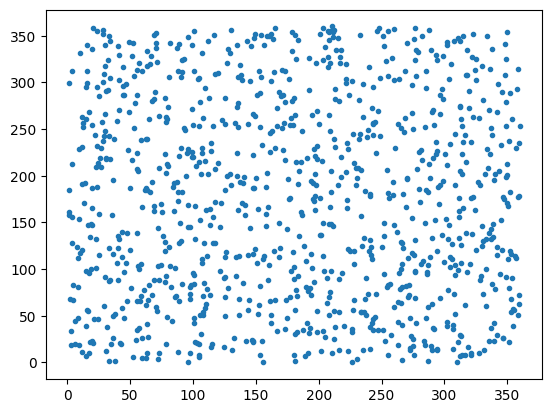

In [2]:
#  Create a set of random stars in range [360,360]
n_stars = 1000

# Create the set of points
x = np.random.uniform(0, 360, n_stars)
y = np.random.uniform(0, 360, n_stars)
stars_id = np.linspace(0,n_stars-1,n_stars, dtype=int)

stars_data = np.array( np.transpose([x,y, stars_id]))

print(stars_data.shape)

for i in range(5):
    print("Star ID: ", stars_data[i][2], ", lat:", stars_data[i][0], ", len: ", stars_data[i][1])

plt.figure()
plt.plot(x,y,'.')
plt.show()

In [47]:
from scipy.spatial import KDTree

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,:2])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,:2], k=n_of_neighbor+1)

features_vec_1 = []
features_vec_2 = []


# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    print("Star ID:", stars_data[i][2], "(","%0.2f" % stars_data[i][0],",","%0.2f" %stars_data[i][1],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        x_distance = stars_data[neighbor_index][0] - stars_data[i][0]
        y_distance = stars_data[neighbor_index][1] - stars_data[i][1]
        print("Neighbor ID:", stars_data[neighbor_index][2], "(","%0.2f" %stars_data[neighbor_index][0],",","%0.2f" %stars_data[neighbor_index][1],")", ", x-distance:", x_distance, ", y-distance:", y_distance)

        #  Define the features vector that is going to be used in the SOM:
        # TODO: Try diferent combinations of features to set the most efective one

        # features = [ x1-x2, y1-y2, x1-x3, y1-y3, ..., x1-x_n, y1-y_n]
        features_1.append(x_distance)
        features_1.append(y_distance)

        # fetaures = [ r1 * r2, r1*r3, r1*r_n]
        features_2.append(stars_data[neighbor_index][0] * stars_data[i][0]
                        + stars_data[neighbor_index][1] * stars_data[i][1]) 

        # Inter neighbor features
        # features = [ x2-x3, y2-y3, x2-x4, y2-y4, ..., x_m-x_n, y_m-y_n]
        # for k in range(1,n_of_neighbor+1-j):
        #     features.append()

    features_vec_1.append(features_1)
    features_vec_2.append(features_2)

    print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]))

Star ID: 0.0 ( 166.87 , 272.54 )
Neighbor ID: 220.0 ( 173.41 , 279.21 ) , x-distance: 6.535153138663702 , y-distance: 6.6699652584360365
Neighbor ID: 87.0 ( 169.66 , 285.98 ) , x-distance: 2.7920937761334983 , y-distance: 13.44002349357396
Neighbor ID: 370.0 ( 178.79 , 280.31 ) , x-distance: 11.915003936218 , y-distance: 7.769102046229307
Neighbor ID: 138.0 ( 171.88 , 286.00 ) , x-distance: 5.006052893264808 , y-distance: 13.459070620169314
Number of features:  8 , 4
Star ID: 1.0 ( 242.55 , 42.33 )
Neighbor ID: 861.0 ( 243.44 , 46.73 ) , x-distance: 0.886922162902323 , y-distance: 4.401879330121091
Neighbor ID: 248.0 ( 240.50 , 37.84 ) , x-distance: -2.045725509381441 , y-distance: -4.4912837175899085
Neighbor ID: 168.0 ( 244.74 , 48.58 ) , x-distance: 2.1891172565507873 , y-distance: 6.253778444145858
Neighbor ID: 52.0 ( 243.16 , 35.10 ) , x-distance: 0.6151178492512202 , y-distance: -7.23070458139447
Number of features:  8 , 4
Star ID: 2.0 ( 63.13 , 239.81 )
Neighbor ID: 157.0 ( 62.3

In [122]:

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

# Must be more neurons that points -> sqrt of data size to set the mesh: data < som_rows * som_cols
# Initialize the SOM
som1 = MiniSom(
    x = np.int(np.sqrt(features_1_n.shape[0])/2) ,
    y = np.int(np.sqrt(features_1_n.shape[0])/2),
    input_len = features_1_n.shape[1],
    sigma=1.0,
    learning_rate=0.7,
    neighborhood_function='gaussian',
)
som2 = MiniSom(
    x = np.int(np.sqrt(features_2_n.shape[0])/2),
    y = np.int(np.sqrt(features_2_n.shape[0])/2),
    input_len = features_2_n.shape[1],
    sigma=1.0,
    learning_rate=0.7,
    neighborhood_function='gaussian',
)

# Train the SOM
som1.train_random(data=features_1_n, num_iteration=100000, verbose= True)
som2.train_random(data=features_2_n, num_iteration=100000, verbose= True)


/tmp/ipykernel_4146/129167464.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.int(np.sqrt(features_1_n.shape[0])/2) ,
/tmp/ipykernel_4146/129167464.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in N

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.19007375920257522
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.00924617109831405


In [123]:
# Check that neurons correspond to a star, the rest of the neurons don't have any star ID set,
#  this also imply that there are some neurons with more than one star parameters stored 

# Another dict for map neurons to star (just to check), same as star_ids but created from som.winner rather than som.winner_map
def add_values_in_dict(sample_dict, key, list_of_values):
    ''' Append multiple values to a key in 
        the given dictionary '''
    if key not in sample_dict:
        sample_dict[key] = list()
    sample_dict[key].extend(list_of_values)
    return sample_dict

star_dict_1= {}
star_dict_2= {}

for i in range(len(features_1_n)):
    star_dict_1 = add_values_in_dict(star_dict_1, som1.winner(features_1_n[i]),[i])
    star_dict_2 = add_values_in_dict(star_dict_2, som2.winner(features_2_n[i]),[i])


print("Number of neurons with data:",len(star_dict_1),"; Total neurons:", som1._xx.shape[0]*som1._xx.shape[1])
print("Number of neurons with data:",len(star_dict_2),"; Total neurons:", som2._xx.shape[0]*som2._xx.shape[1])
star_dict_1

Number of neurons with data: 225 ; Total neurons: 225
Number of neurons with data: 225 ; Total neurons: 225


{(8, 6): [0, 104, 246],
 (4, 9): [1, 22, 302, 322, 356, 562, 650],
 (3, 13): [2, 157, 499, 517, 727, 790],
 (0, 14): [3, 9, 111, 143, 573, 585, 909, 910, 938, 953, 979],
 (6, 3): [4, 78, 166, 547, 580, 980],
 (8, 1): [5, 243, 259, 511, 625, 851, 866, 913],
 (11, 5): [6, 83],
 (13, 14): [7],
 (3, 10): [8, 250, 541, 626, 861],
 (10, 6): [10],
 (10, 9): [11, 232, 759],
 (5, 3): [12, 72, 114, 200, 679],
 (6, 11): [13, 99, 611],
 (2, 11): [14, 353, 704],
 (13, 0): [15, 144, 312],
 (9, 2): [16, 69, 463, 729, 819, 860, 894],
 (1, 14): [17, 98, 273, 292, 394, 862],
 (2, 8): [18, 189, 413, 514, 848, 924],
 (9, 0): [19],
 (10, 11): [20, 214, 328, 492],
 (7, 1): [21, 165, 202, 375, 810, 827],
 (5, 6): [23, 581],
 (3, 14): [24, 27],
 (11, 3): [25, 89, 116, 308, 332, 493, 531, 600, 912],
 (1, 5): [26, 333, 381, 457, 782, 828, 900],
 (11, 7): [28, 300, 421, 470, 498, 939],
 (14, 8): [29, 63, 126, 184, 365, 401, 818],
 (7, 8): [30, 187],
 (8, 8): [31, 341, 342, 357, 374, 474, 703, 722],
 (11, 9): [32

SOM1: Predicted Stars ID: [249, 587, 761, 890]
SOM2: Predicted Stars ID: [47, 249, 343, 394, 411, 629, 693, 801, 855]
Final guees: 249, actual star ID: 249


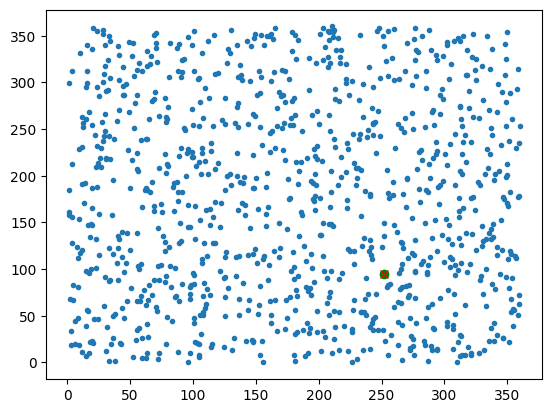

In [130]:
# Define a function to predict the star ID for a given feature vector
def predict_star_id(features, features_array, dictionary, som):
    normalized_feature = (features - features_array.min(axis=0)) / (features_array.max(axis=0) - features_array.min(axis=0))
    winner = som.winner(normalized_feature)
    if winner in dictionary:
        return dictionary[winner]
    else:
        return 
    
# Test the prediction for a sample feature vector
random_id = np.random.randint(0,len(features_vec_1))

sample_feature_1= features_vec_1[random_id] 
sample_feature_2= features_vec_2[random_id] 

predicted_star_ids_1 = predict_star_id(sample_feature_1,np.array(features_vec_1),star_dict_1,som1)
predicted_star_ids_2 = predict_star_id(sample_feature_2,np.array(features_vec_2),star_dict_2,som2)

if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2:
    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]

print(f"SOM1: Predicted Stars ID: {predicted_star_ids_1}")
print(f"SOM2: Predicted Stars ID: {predicted_star_ids_2}" )
print(f"Final guees: {star_guess}, actual star ID: {random_id}")

plt.figure()
plt.plot(x,y,'.')
plt.plot(stars_data[random_id][0],stars_data[random_id][1],'og')
plt.plot(stars_data[star_guess][0],stars_data[star_guess][1],'xr')
plt.show()


In [140]:
cont = 0
for i in range(features_vec_1.shape[0]):
    
    # Itroduce noise in the features vector to check the response of the SOM

    loc = 0 
    scale = 1.0
    sample_feature_1= features_vec_1[i] - np.random.normal(loc=loc, scale=scale, size=features_vec_1.shape[1])
    sample_feature_2= features_vec_2[i] - np.random.normal(loc=loc, scale=scale, size=features_vec_2.shape[1])


    predicted_star_ids_1 = predict_star_id(sample_feature_1,np.array(features_vec_1),star_dict_1,som1)
    predicted_star_ids_2 = predict_star_id(sample_feature_2,np.array(features_vec_2),star_dict_2,som2)

    if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2:
        star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
    else: 
        print("Error: ", list(set(predicted_star_ids_1).intersection(predicted_star_ids_2)), "!=", i)

    cont += star_guess == i
    
print("total succes =",  cont / features_vec_1.shape[0])

Error:  [2, 157] != 2
Error:  [3, 979, 143] != 3
Error:  [144, 15] != 15
Error:  [600, 25] != 25


IndexError: list index out of range